In [1]:
import numpy as np
import pandas as pd
import random 
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd 
import yaml 
import matplotlib.pyplot as plt; plt.ion()
from matplotlib import rc, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from lenspack.peaks import find_peaks2d


In [2]:
def read_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

config = read_config("../config_sayan.yaml")
center_cl = {"ra_c": 104.629583, "dec_c": -55.946944}

In [3]:
def load_shear_data(shear_cat_path, ra_col, dec_col, g1_col, g2_col, weight_col):
    """ 
    Load shear data from a FITS file and return a pandas DataFrame.

    :param path: Path to the FITS file.
    :param ra_col: Column name for right ascension.
    :param dec_col: Column name for declination.
    :param g1_col: Column name for the first shear component.
    :param g2_col: Column name for the second shear component.
    :param weight_col: Column name for the weight.
    :return: pandas DataFrame with the specified columns.
    """
    # Read data from the FITS file
    shear_catalog = Table.read(shear_cat_path)

    # Convert to pandas DataFrame
    shear_df = pd.DataFrame({
        'ra': shear_catalog[ra_col],
        'dec': shear_catalog[dec_col],
        'g1': shear_catalog[g1_col],
        'g2': shear_catalog[g2_col],
        'weight': shear_catalog[weight_col]
    })

    return shear_df

In [4]:
def calculate_field_boundaries_v2(ra, dec, resolution):
    """
    Calculate the boundaries of the field in right ascension (RA) and declination (Dec).
    
    :param ra: Dataframe column containing the right ascension values.
    :param dec: Dataframe column containing the declination values.
    :param resolution: Resolution of the map in arcminutes.
    :return: A dictionary containing the corners of the map {'ra_min', 'ra_max', 'dec_min', 'dec_max'}.
    """
    # Calculate median RA and Dec
    med_ra = np.median(ra)
    med_dec = np.median(dec)
    
    # Calculate the range of RA and Dec values
    ra_range = np.max(ra) - np.min(ra)
    dec_range = np.max(dec) - np.min(dec)
    
    # Calculate the size of the field in degrees
    ra_size = ra_range * np.cos(np.deg2rad(med_dec))  # Adjust for declination
    dec_size = dec_range
    
    # Calculate RA and Dec extents and store in a dictionary
    boundaries = {
        'ra_min': med_ra - ra_size / 2,
        'ra_max': med_ra + ra_size / 2,
        'dec_min': med_dec - dec_size / 2,
        'dec_max': med_dec + dec_size / 2
    }
    
    return boundaries

In [5]:
def calculate_field_boundaries(ra, dec, resolution):
    """
    Calculate the boundaries of the field in right ascension (RA) and declination (Dec).
    
    :param ra: Dataframe column containing the right ascension values.
    :param dec: Dataframe column containing the declination values.
    :param resolution: Resolution of the map in arcminutes.
    :return: A dictionary containing the corners of the map {'ra_min', 'ra_max', 'dec_min', 'dec_max'}.
    """

    # Calculate RA and Dec extents and store in a dictionary
    boundaries = {
        'ra_min': np.min(ra),
        'ra_max': np.max(ra),
        'dec_min': np.min(dec),
        'dec_max': np.max(dec)
    }
    
    return boundaries

In [6]:
def create_shear_grid(ra, dec, g1, g2, weight, boundaries, resolution):
    '''
    Bin values of shear data according to position on the sky.
    '''
    ra_min, ra_max = boundaries['ra_min'], boundaries['ra_max']
    dec_min, dec_max = boundaries['dec_min'], boundaries['dec_max']
    
    # Calculate number of pixels based on field size and resolution
    npix_ra = int(np.ceil((ra_max - ra_min) * 60 / resolution))
    npix_dec = int(np.ceil((dec_max - dec_min) * 60 / resolution))
    
    ra_bins = np.linspace(ra_min, ra_max, npix_ra + 1)
    dec_bins = np.linspace(dec_min, dec_max, npix_dec + 1)
    
    # Digitize the RA and Dec to find bin indices
    ra_idx = np.digitize(ra, ra_bins) - 1
    dec_idx = np.digitize(dec, dec_bins) - 1
    
    # Filter out indices that are outside the grid boundaries
    valid_mask = (ra_idx >= 0) & (ra_idx < npix_ra) & (dec_idx >= 0) & (dec_idx < npix_dec)
    ra_idx = ra_idx[valid_mask]
    dec_idx = dec_idx[valid_mask]
    g1 = g1[valid_mask]
    g2 = g2[valid_mask]
    weight = weight[valid_mask]
    
    # Initialize the grids
    g1_grid = np.zeros((npix_dec, npix_ra))
    g2_grid = np.zeros((npix_dec, npix_ra))
    weight_grid = np.zeros((npix_dec, npix_ra))
    
    # Accumulate weighted values using np.add.at
    np.add.at(g1_grid, (dec_idx, ra_idx), g1 * weight)
    np.add.at(g2_grid, (dec_idx, ra_idx), g2 * weight)
    np.add.at(weight_grid, (dec_idx, ra_idx), weight)
    
    # Normalize the grid by the total weight in each bin (weighted average)
    #try with commented out 
    nonzero_weight_mask = weight_grid != 0
    g1_grid[nonzero_weight_mask] /= weight_grid[nonzero_weight_mask]
    g2_grid[nonzero_weight_mask] /= weight_grid[nonzero_weight_mask]
    
    return g1_grid, g2_grid

In [7]:
def ks_inversion(g1_grid, g2_grid):
    """
    Perform the Kaiser-Squires inversion to obtain both E-mode and B-mode convergence maps from shear components.
    """
    # Get the dimensions of the input grids
    npix_dec, npix_ra = g1_grid.shape

    # Fourier transform the shear components
    g1_hat = np.fft.fft2(g1_grid)
    g2_hat = np.fft.fft2(g2_grid)

    # Create a grid of wave numbers
    k1, k2 = np.meshgrid(np.fft.fftfreq(npix_ra), np.fft.fftfreq(npix_dec))
    k_squared = k1**2 + k2**2

    # Avoid division by zero by replacing zero values with a small number
    k_squared = np.where(k_squared == 0, np.finfo(float).eps, k_squared)

    # Kaiser-Squires inversion in Fourier space
    kappa_e_hat = (1 / k_squared) * ((k1**2 - k2**2) * g1_hat + 2 * k1 * k2 * g2_hat)
    kappa_b_hat = (1 / k_squared) * ((k1**2 - k2**2) * g2_hat - 2 * k1 * k2 * g1_hat)

    # Inverse Fourier transform to get the convergence maps
    kappa_e_grid = np.real(np.fft.ifft2(kappa_e_hat))
    kappa_b_grid = np.real(np.fft.ifft2(kappa_b_hat))

    return kappa_e_grid, kappa_b_grid

In [8]:
def plot_convergence_v3(convergence, boundaries, config, center_cl=None, smoothing=None, vmax=None, vmin=None, title="1.5 arcmin smoothing", threshold=None):
    """
    Make plot of convergence map and save to file using information passed
    in run configuration file. 

    Arguments
        convergence: XXX raw convergence map XXX
        boundaries: XXX RA/Dec axis limits for plot, set in XXX
        config: overall run configuration file

    """

    # Embiggen font sizes, tick marks, etc.
    fontsize = 15
    plt.rcParams.update({'axes.linewidth': 1.3})
    plt.rcParams.update({'xtick.labelsize': fontsize})
    plt.rcParams.update({'ytick.labelsize': fontsize})
    plt.rcParams.update({'xtick.major.size': 8})
    plt.rcParams.update({'xtick.major.width': 1.3})
    plt.rcParams.update({'xtick.minor.visible': True})
    plt.rcParams.update({'xtick.minor.width': 1.})
    plt.rcParams.update({'xtick.minor.size': 6})
    plt.rcParams.update({'xtick.direction': 'in'})
    plt.rcParams.update({'ytick.major.width': 1.3})
    plt.rcParams.update({'ytick.major.size': 8})
    plt.rcParams.update({'ytick.minor.visible': True})
    plt.rcParams.update({'ytick.minor.width': 1.})
    plt.rcParams.update({'ytick.minor.size':6})
    plt.rcParams.update({'ytick.direction':'in'})
    plt.rcParams.update({'axes.labelsize': fontsize})
    plt.rcParams.update({'axes.titlesize': fontsize})

    
    # Apply Gaussian filter -- is this the right place to do it?
    # We are planning on implementing other filters at some point, right?
    #filtered_convergence = gaussian_filter(convergence, config['gaussian_kernel'])
    
    if smoothing is not None:
        filtered_convergence = gaussian_filter(convergence, smoothing)
    else:
        filtered_convergence = convergence
        
    if threshold is not None:
        y, x, h = find_peaks2d(filtered_convergence, threshold=threshold, include_border=False)
    else: # empty lists
        x, y, h = [], [], []
        

    # Make the plot!
    fig, ax = plt.subplots(
        nrows=1, ncols=1, figsize=config['figsize'], tight_layout=True
    )
    
    im = ax.imshow(
        filtered_convergence[:,::-1],  # flip the x axis
        cmap=config['cmap'],
        vmax=vmax, 
        vmin=vmin,
        extent=[ boundaries['ra_max'], boundaries['ra_min'],  
                    boundaries['dec_min'], 
                    boundaries['dec_max']],
        origin='lower' # Sets the origin to bottom left to match the RA/DEC convention
    )  
    if center_cl is not None:
        ra_c, dec_c = center_cl["ra_c"], center_cl["dec_c"]
        ax.plot(ra_c, dec_c, 'wx', markersize=10)
    
    # convert x,y to ra,dec
    ra_peak, dec_peak = [], []
    for i in range(len(x)):
        ra_peak.append(boundaries['ra_min'] + (x[i]+0.5) * (boundaries['ra_max'] - boundaries['ra_min']) / filtered_convergence.shape[1])
        dec_peak.append(boundaries['dec_min'] + (y[i]+0.5) * (boundaries['dec_max'] - boundaries['dec_min']) / filtered_convergence.shape[0])
    
    ax.scatter(ra_peak, dec_peak, s=100, facecolors='none', edgecolors='g', linewidth=1.5)
    
    #ax.scatter(x, y, s=100, facecolors='none', edgecolors='g', linewidth=1.5)

    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel(config['ylabel'])
    ax.set_title(title)
    ax.set_aspect('equal')

    # Is there a better way to force something to be a boolean?
    if config['gridlines'] == True:
        ax.grid(color='black')

    # Add colorbar; turn off minor axes first
    plt.rcParams.update({'ytick.minor.visible': False})
    plt.rcParams.update({'xtick.minor.visible': False})

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    fig.colorbar(im, cax=cax)

    # Save to file and exit, redoing tight_layout b/c sometimes figure gets cut off 
    fig.tight_layout() 
    plt.show()
    #fig.savefig(config['output_path'])
    plt.close(fig)

In [9]:
shear_df = load_shear_data(config['input_path'], 
                                          config['ra_col'], 
                                          config['dec_col'], 
                                          config['g1_col'], 
                                          config['g2_col'], 
                                          config['weight_col'])
print(shear_df)

              ra        dec        g1        g2    weight
0     104.655406 -56.087883 -0.457485 -0.180171  4.992211
1     104.832843 -56.089083  0.615724 -0.462868  0.185507
2     104.783309 -56.089084 -0.810462 -0.568627  3.730110
3     104.770202 -56.089269 -1.880139 -0.534132  0.389534
4     104.799904 -56.089313 -0.849809 -0.129802  4.599156
...          ...        ...       ...       ...       ...
3604  104.581113 -55.930026  1.060091 -0.287627  4.570508
3605  104.731479 -55.930364  0.312710  0.425442  4.731398
3606  104.303661 -55.928424 -0.692010 -0.381118  4.801212
3607  104.937961 -55.930362 -0.678165 -0.330260  4.985500
3608  104.467693 -55.930481 -0.098573  0.260276  4.724180

[3609 rows x 5 columns]


In [10]:
def correct_RA_dec(shear_df):
    shear_df_f = shear_df.copy()
    ra = shear_df['ra']
    dec = shear_df['dec']
    ra_0 = (np.max(ra) + np.min(ra))/2 # center of ra, set as a refernce for this transformation
    dec_0 = (np.max(dec) + np.min(dec))/2 # center of dec, set as a refernce for this transformation
    
    ra_flat, dec_flat = np.zeros(len(ra)), np.zeros(len(dec))
    for i in range(len(ra)):
        ra_flat[i] = (ra[i] - ra_0) * np.cos(np.deg2rad(dec[i]))
        dec_flat[i] = dec[i] - dec_0
    shear_df_f['ra'] = ra_flat
    shear_df_f['dec'] = dec_flat
    return shear_df_f

In [11]:
shear_df_f = correct_RA_dec(shear_df)

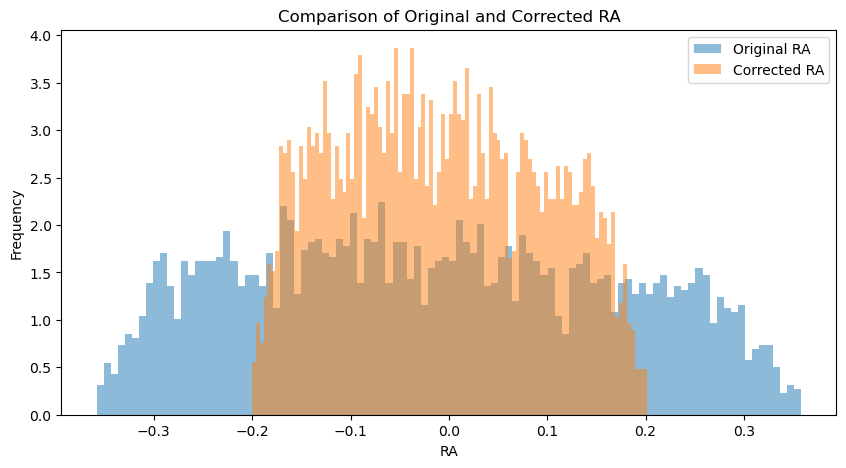

In [12]:
ra_0 = (np.max(shear_df['ra']) + np.min(shear_df['ra']))/2
plt.figure(figsize=(10, 5))
plt.hist(shear_df['ra'] - ra_0, bins=100, alpha=0.5,density=1, label='Original RA')
plt.hist(shear_df_f['ra'], bins=100, alpha=0.5,density=1, label='Corrected RA')
plt.xlabel('RA')
plt.ylabel('Frequency')
plt.title('Comparison of Original and Corrected RA')
plt.legend()
plt.show()

In [13]:
boundaries = calculate_field_boundaries(shear_df['ra'], shear_df['dec'], config['resolution'])
boundaries_f = calculate_field_boundaries(shear_df_f['ra'], shear_df_f['dec'], config['resolution'])

In [14]:
g1map_og_1, g2map_og_1 = create_shear_grid(shear_df['ra'], 
                                       shear_df['dec'], 
                                       shear_df['g1'],
                                       shear_df['g2'], 
                                       shear_df['weight'], 
                                       boundaries=boundaries,
                                       resolution=config['resolution'])
og_kappa_e_1, og_kappa_b_1 = ks_inversion(g1map_og_1, g2map_og_1)



# Finally, computing the oringinal kappa map
g1map_og_2, g2map_og_2 = create_shear_grid(shear_df_f['ra'], 
                                       shear_df_f['dec'], 
                                       shear_df_f['g1'],
                                       shear_df_f['g2'], 
                                       shear_df_f['weight'], 
                                       boundaries=boundaries_f,
                                       resolution=config['resolution'])
og_kappa_e_2, og_kappa_b_2 = ks_inversion(g1map_og_2, g2map_og_2)

In [15]:
ra_0 = (boundaries['ra_min'] + boundaries['ra_max'])/2
dec_0 = (boundaries['dec_min'] + boundaries['dec_max'])/2

boundaries_f_shifted = {"ra_min": boundaries_f['ra_min'] + ra_0, "ra_max": boundaries_f['ra_max'] + ra_0, "dec_min": boundaries_f['dec_min'] + dec_0, "dec_max": boundaries_f['dec_max'] + dec_0}

In [16]:
trunc_left = (boundaries_f_shifted['ra_min'] - boundaries['ra_min']) * 60 / config['resolution']
trunc_right = og_kappa_e_1.shape[1] - ((boundaries['ra_max'] - boundaries_f_shifted['ra_max']) * 60 / config['resolution'])

og_kappa_e_1_trunc = og_kappa_e_1[:, int(trunc_left):int(trunc_right)]

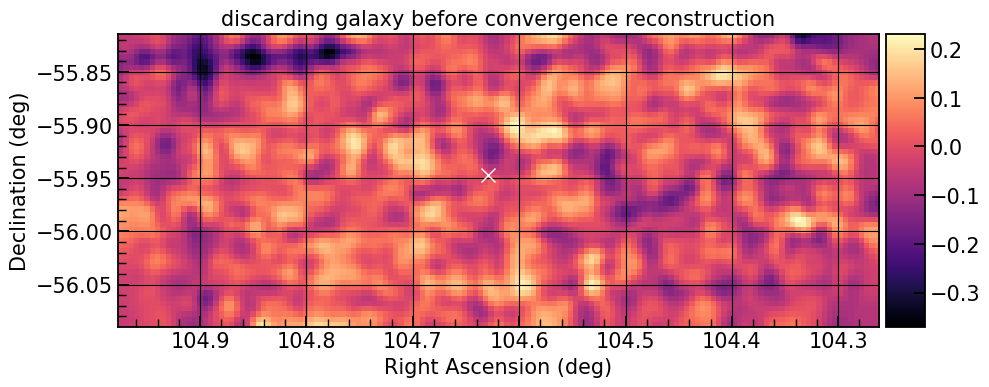

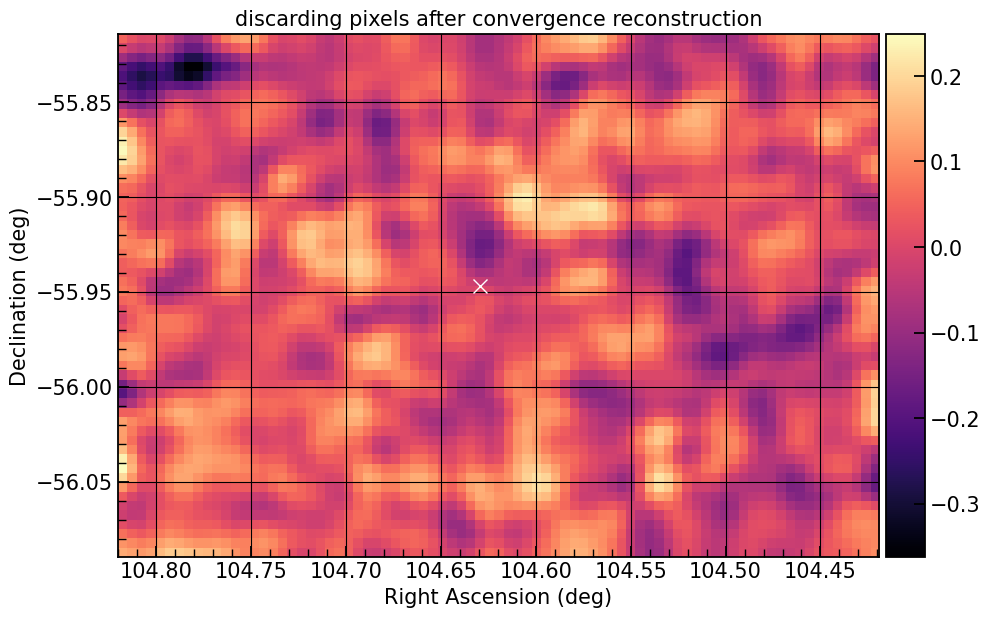

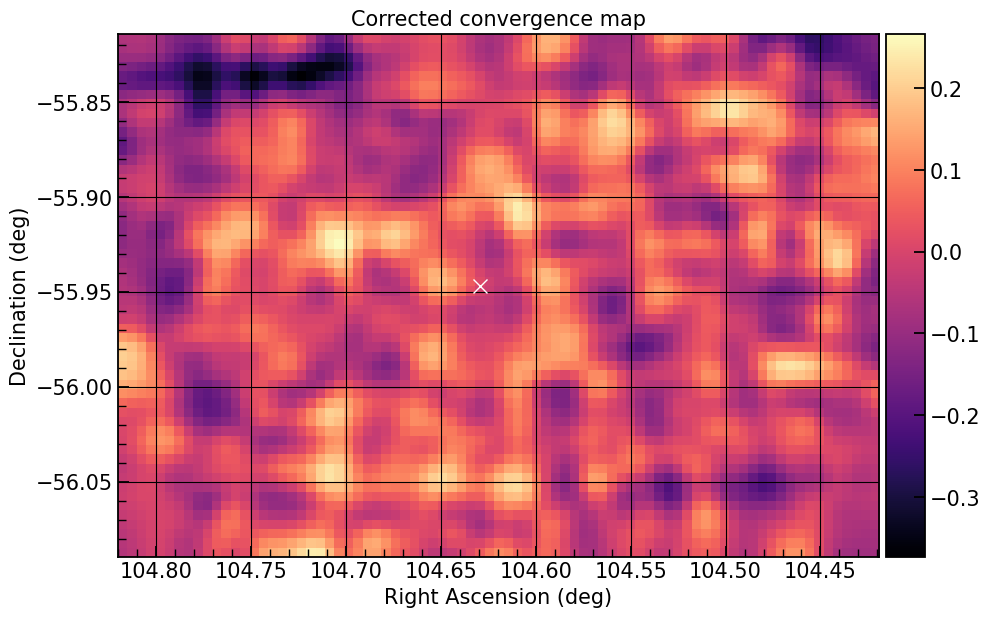

In [17]:
#center_cl = {"ra_c": 0, "dec_c": 0}

plot_convergence_v3(og_kappa_e_1, boundaries, config, center_cl=center_cl, smoothing=1.5, title="discarding galaxy before convergence reconstruction")
plot_convergence_v3(og_kappa_e_1_trunc, boundaries_f_shifted, config, center_cl, smoothing=1.5, title="discarding pixels after convergence reconstruction")
plot_convergence_v3(og_kappa_e_2, boundaries_f_shifted, config, center_cl=center_cl, smoothing=1.5, title="Corrected convergence map")